In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv

Zkouška podle předlohy:

In [2]:
def tanimoto(vector1, vector2):
    set_bits = 0
    shared_bits = 0
    for bit1, bit2 in zip(vector1, vector2):
        if bit1 or bit2:
            set_bits += 1
            if bit1 and bit2:
                shared_bits += 1
    return shared_bits / set_bits

print(tanimoto([1, 1, 0, 0], [0, 0, 1, 1]))
print(tanimoto([0, 1, 1, 0], [1, 0, 1, 0]))
print(tanimoto([1, 1, 1, 1], [0, 0, 1, 1]))
print(tanimoto([1, 1, 1, 1], [0, 1, 1, 1]))
print(tanimoto([1, 1, 0, 0], [1, 1, 0, 0]))

0.0
0.3333333333333333
0.5
0.75
1.0


In [3]:
with open('chembl_thrombin_ic50.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    thrombin_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier('drugbank.sdf')
drugs = [m for m in suppl if m]

RDKit ERROR: [18:07:13] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [18:07:13] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [18:07:13] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [18:07:13] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [18:07:13] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [18:07:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [18:07:13] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [18:07:13] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [18:07:13] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [18:07:13] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [18:07:13] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [18:07:13] Can't kek

Připomenutí kolik mám čeho:

In [4]:
print(len(thrombin_ligands))
print(len(drugs))

3236
7113


Opět zkoušení podle předlohy:

In [5]:
from rdkit.Chem import MACCSkeys
fp1 = MACCSkeys.GenMACCSKeys(drugs[123])
fp2 = MACCSkeys.GenMACCSKeys(drugs[666])
print(fp1.ToBitString())
print(fp2.ToBitString())

00000000000000000000000000000000000000000000000000000100000000000000000000000000000010000100000001000000000000000100000000010001000101010001000110100011101011110111110
00000000000000000000000000000010000000000000000001000000010000000000000000100000000001100000010100101100010011011101101000110110000010000110010011111100111111111111110


In [6]:
tanimoto(fp1, fp2)

0.25

Aktivace similarity metrics:

In [7]:
from rdkit import DataStructs

In [8]:
DataStructs.TanimotoSimilarity(fp1, fp2)

0.25

In [9]:
thrombin_ligands_maccs = [MACCSkeys.GenMACCSKeys(m) for m in thrombin_ligands]
drugs_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drugs]

Také nastavuji na 80% a zkouším s aspirinem:

In [10]:
def similarity_search(query_fp, searched_fp_set, cutoff=0.8):
    hits = []
    for i, fp in enumerate(searched_fp_set):
        similarity = DataStructs.TanimotoSimilarity(query_fp, fp)
        if similarity >= cutoff:
            hits.append((i, similarity))
    return sorted(hits, key=lambda x: x[1], reverse=True)

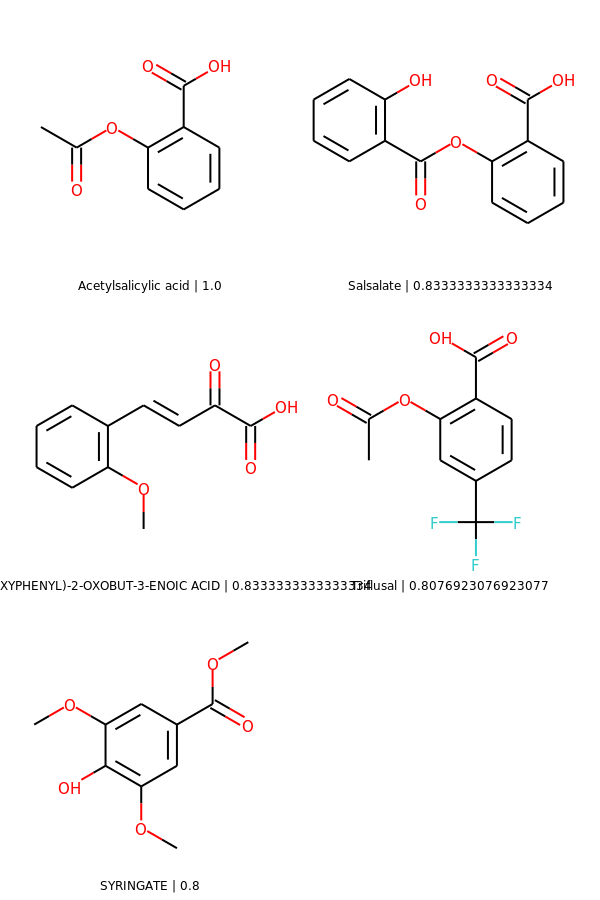

In [11]:
aspirin = Chem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')
aspirin_fp = MACCSkeys.GenMACCSKeys(aspirin)
hits = similarity_search(aspirin_fp, drugs_maccs)
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=["{} | {}".format(drugs[hit[0]].GetProp('GENERIC_NAME'), hit[1]) for hit in hits])

Zkouším to samé s indomethacinem:

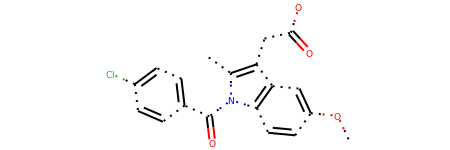

In [12]:
indomethacin = Chem.MolFromSmarts("CC1=C(C2=C(N1C(C3=CC=C(Cl)C=C3)=O)C=CC(OC)=C2)CC(O)=O")
indomethacin

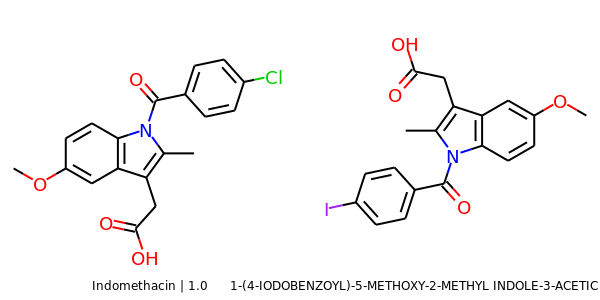

In [13]:
indomethacin = Chem.MolFromSmiles('CC1=C(C2=C(N1C(C3=CC=C(Cl)C=C3)=O)C=CC(OC)=C2)CC(O)=O')
indomethacin_fp = MACCSkeys.GenMACCSKeys(indomethacin)
hits = similarity_search(indomethacin_fp, drugs_maccs)
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=["{} | {}".format(drugs[hit[0]].GetProp('GENERIC_NAME'), hit[1]) for hit in hits])

Ejhle, nalezlo jen indomethacin samotný a dále jen vcelku nudnou modifikace, kde je namísto chloru jód. Bohužel tu ale nevidím číselně vyjádřenou podobnost - docela by mě zajímalo, jak s tím ten jód hne.

Látky z Drugbanku podobné látce č. 0 z mého setu:

In [14]:
hits = similarity_search(thrombin_ligands_maccs[0], drugs_maccs)
hits

[(3768, 0.8433734939759037),
 (2403, 0.8372093023255814),
 (2420, 0.8351648351648352),
 (168, 0.8222222222222222),
 (3667, 0.8117647058823529)]

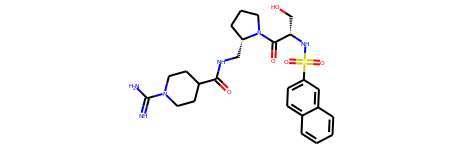

In [15]:
thrombin_ligands[0]

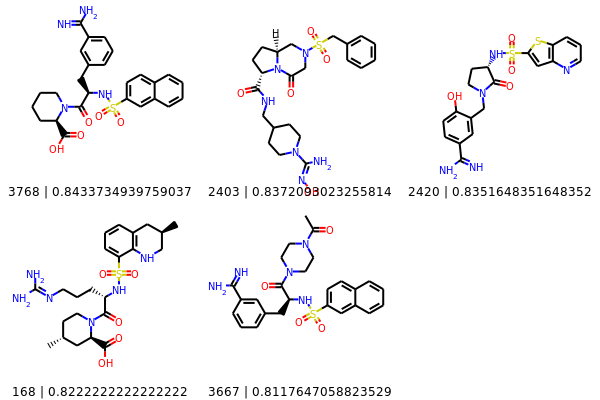

In [16]:
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits], legends=["{} | {}".format(hit[0], hit[1]) for hit in hits])

Vizualizace oněch pěti látek z DB, co jsou podobné ligandu 0.

Využití ECFP:

In [17]:
thrombin_ligands_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
                     for m in thrombin_ligands]
drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
              for m in drugs]

In [18]:
hits = similarity_search(thrombin_ligands_ecfp[0], drugs_ecfp)
hits

[]

Taktéž žádná podobnost.

In [19]:
DataStructs.TanimotoSimilarity(thrombin_ligands_ecfp[0], drugs_ecfp[3768])

0.5

In [20]:
DataStructs.TanimotoSimilarity(thrombin_ligands_ecfp[0], drugs_ecfp[2403])

0.2857142857142857

In [21]:
DataStructs.TanimotoSimilarity(thrombin_ligands_ecfp[0], drugs_ecfp[2420])

0.2

In [22]:
DataStructs.TanimotoSimilarity(thrombin_ligands_ecfp[0], drugs_ecfp[168])

0.2571428571428571

In [23]:
DataStructs.TanimotoSimilarity(thrombin_ligands_ecfp[0], drugs_ecfp[3667])

0.43373493975903615

Zkusil jsem všech 5 hitů z MACCS. Ve všech případech tu nějaká podobnost je, ale je velmi malá - žádná z nich nepřesáhla 0.5.

Hledání ligandů v DB:

In [24]:
thrombin_ligands_queries = [(i, similarity_search(ligand_ecfp, drugs_ecfp))
                     for i, ligand_ecfp in enumerate(thrombin_ligands_ecfp)]
thrombin_ligands_queries

[(0, []),
 (1, []),
 (2, []),
 (3, []),
 (4, []),
 (5, []),
 (6, []),
 (7, []),
 (8, []),
 (9, []),
 (10, []),
 (11, []),
 (12, []),
 (13, []),
 (14, []),
 (15, []),
 (16, []),
 (17, []),
 (18, []),
 (19, []),
 (20, []),
 (21, []),
 (22, []),
 (23, []),
 (24, []),
 (25, []),
 (26, []),
 (27, []),
 (28, []),
 (29, []),
 (30, []),
 (31, []),
 (32, []),
 (33, []),
 (34, []),
 (35, []),
 (36, []),
 (37, []),
 (38, []),
 (39, []),
 (40, []),
 (41, []),
 (42, []),
 (43, []),
 (44, []),
 (45, []),
 (46, []),
 (47, []),
 (48, []),
 (49, []),
 (50, []),
 (51, []),
 (52, []),
 (53, []),
 (54, []),
 (55, []),
 (56, []),
 (57, []),
 (58, []),
 (59, []),
 (60, []),
 (61, []),
 (62, []),
 (63, []),
 (64, []),
 (65, []),
 (66, []),
 (67, []),
 (68, []),
 (69, []),
 (70, []),
 (71, []),
 (72, []),
 (73, []),
 (74, []),
 (75, []),
 (76, []),
 (77, []),
 (78, []),
 (79, []),
 (80, []),
 (81, []),
 (82, []),
 (83, []),
 (84, []),
 (85, []),
 (86, []),
 (87, []),
 (88, []),
 (89, []),
 (90, []),
 (91, [])

Vyfiltrování hitů:

In [25]:
thrombin_ligand_hits = [hit for hit in thrombin_ligands_queries if hit[1]]
thrombin_ligand_hits

[(240, [(5489, 1.0), (5490, 1.0)]),
 (409, [(4718, 0.859375)]),
 (651, [(1519, 0.8307692307692308), (3667, 0.8225806451612904)]),
 (809, [(5373, 0.8305084745762712)]),
 (850, [(5387, 1.0)]),
 (950, [(5373, 0.8166666666666667)]),
 (1013, [(6030, 1.0)]),
 (1098, [(5373, 1.0)]),
 (1388, [(6323, 1.0)]),
 (1397, [(4718, 0.859375)]),
 (1429, [(3747, 1.0)]),
 (1430, [(6998, 1.0)]),
 (1441, [(2102, 1.0)]),
 (1730, [(5489, 1.0), (5490, 1.0)]),
 (1733, [(5489, 1.0), (5490, 1.0)]),
 (1785, [(3747, 1.0)]),
 (1797, [(1723, 1.0)]),
 (1831, [(6954, 0.8809523809523809)]),
 (1996, [(5002, 1.0)]),
 (2130, [(3905, 0.8271604938271605)]),
 (2133, [(5391, 1.0)]),
 (2285, [(5219, 0.9583333333333334)]),
 (2299, [(5489, 0.9836065573770492), (5490, 0.9836065573770492)]),
 (2321, [(4611, 1.0)]),
 (2332, [(5391, 1.0)]),
 (2420, [(5820, 1.0)]),
 (2501, [(5489, 1.0), (5490, 1.0)]),
 (2502, [(5489, 0.9672131147540983), (5490, 0.9672131147540983)]),
 (2508, [(3905, 0.8554216867469879)]),
 (2524, [(5499, 0.80327868852

In [26]:
len(thrombin_ligands_queries), len(thrombin_ligand_hits)

(3236, 39)

39 hitů z 3236 látek.

Hit s č. 1 a jeho vizualizace:

In [27]:
thrombin_ligand_hits[1]

(409, [(4718, 0.859375)])

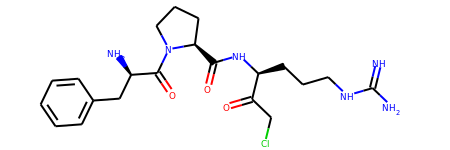

In [28]:
thrombin_ligands[thrombin_ligand_hits[1][0]]

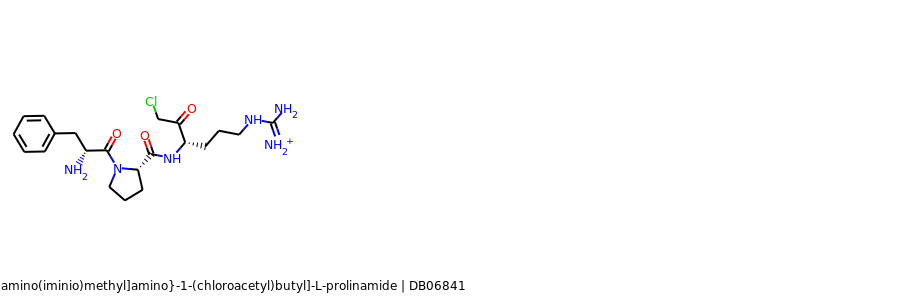

In [29]:
hit_mols = [drugs[index] for index, similarity in thrombin_ligand_hits[1][1]]
Draw.MolsToGridImage(hit_mols, molsPerRow=3, subImgSize=(300,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in hit_mols])

Jak bylo vidno, hituje jen sám sebe.

Všechny DB hity z thrombinových ligandů:

In [30]:
drugs_hitcounts = {}
for ligand, hits in thrombin_ligand_hits:
    for hit, similarity in hits:
        drugs_hitcounts[hit] = drugs_hitcounts.get(hit, 0) + 1
drugs_hitcounts

{5489: 7,
 5490: 7,
 4718: 2,
 1519: 1,
 3667: 1,
 5373: 5,
 5387: 1,
 6030: 1,
 6323: 1,
 3747: 2,
 6998: 2,
 2102: 1,
 1723: 1,
 6954: 1,
 5002: 1,
 3905: 2,
 5391: 2,
 5219: 1,
 4611: 2,
 5820: 1,
 5499: 1,
 4505: 1,
 6661: 1,
 5412: 1,
 2875: 1,
 4501: 1}

Seřazeno:

In [31]:
ordered_drugs_hitcounts = sorted(drugs_hitcounts.keys(), key=lambda x: drugs_hitcounts[x], reverse=True)
ordered_drugs_hitcounts

[5489,
 5490,
 5373,
 4718,
 3747,
 6998,
 3905,
 5391,
 4611,
 1519,
 3667,
 5387,
 6030,
 6323,
 2102,
 1723,
 6954,
 5002,
 5219,
 5820,
 5499,
 4505,
 6661,
 5412,
 2875,
 4501]

Vizualizace štofů:

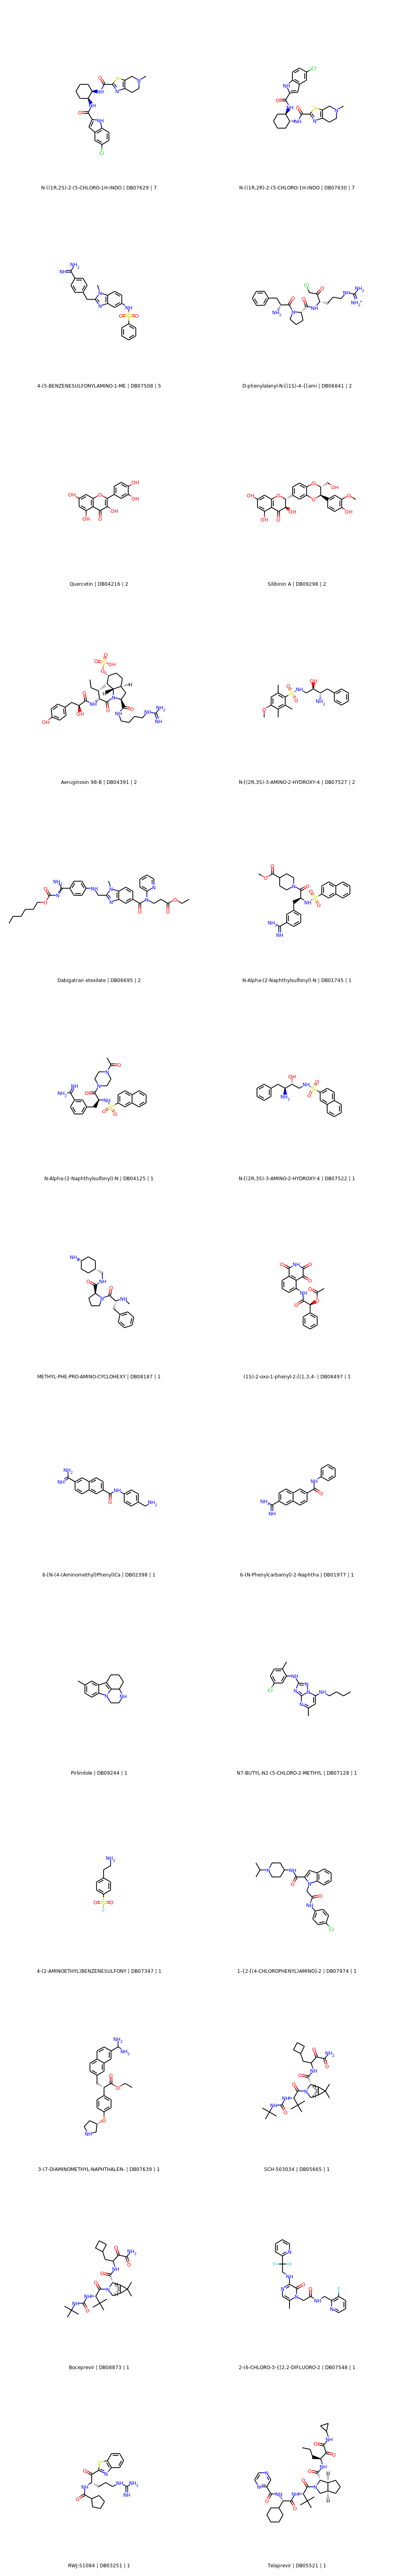

In [32]:
hit_mols = [drugs[i] for i in ordered_drugs_hitcounts]
Draw.MolsToGridImage(hit_mols, molsPerRow=2, subImgSize=(500,500),
                     legends=["{} | {} | {}".format(drugs[i].GetProp('GENERIC_NAME')[:30],
                                                    drugs[i].GetProp('DRUGBANK_ID'),
                                                    drugs_hitcounts[i])
                              for i in ordered_drugs_hitcounts])

Do bulvy mě praštily látky quercetin a silibinin A, které jsou součástí silymarinového komplexu, kterého se týkalo asi půl státnicové otázky a která mi vůbec nelezla do hlavy. Ještě teď mi je z toho ouzko.

Diversity picking:

In [33]:
def distance_function(index1, index2, *args, cheminformaticsfingerprints=thrombin_ligands_ecfp,
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

Zkusil jsem zpracovat ono 1 %, ale bohužel mám tuto chybovou hlášku. Zkoušel jsem to pogooglit, ale nic užitečného jsem nenašel.

In [34]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(thrombin_ligands), 32))
picked

NameError: name 'fingerprints' is not defined